In [5]:
# prepare the R environment
if (!require("pacman")) install.packages("pacman",repos="http://cran.us.r-project.org")
pacman::p_load(
  dplyr,         # Data munging functions
  zoo,              # Feature engineering rolling aggregates
  data.table,       # Feature engineering
  ggplot2,          # Graphics
  scales,           # Time formatted axis
  readr,            # Reading input files
  stringr,          # String functions
  reshape2,         # restructure and aggregate data 
  randomForest,     # Random forests
  corrplot,         # correlation plots
  Metrics,          # Eval metrics for ML
  vcd               # Visualizing discrete distributions
)

# set options for plots
options(repr.plot.width=6, repr.plot.height=6)

Loading required package: pacman
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'pacman'"Installing package into 'C:/Program Files/R/R-3.5.1/library'
(as 'lib' is unspecified)
also installing the dependencies 'memoise', 'git2r', 'devtools'



package 'memoise' successfully unpacked and MD5 sums checked
package 'git2r' successfully unpacked and MD5 sums checked
package 'devtools' successfully unpacked and MD5 sums checked
package 'pacman' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Mirela\AppData\Local\Temp\Rtmpm27vZ1\downloaded_packages


Installing package into 'C:/Program Files/R/R-3.5.1/library'
(as 'lib' is unspecified)


package 'corrplot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Mirela\AppData\Local\Temp\Rtmpm27vZ1\downloaded_packages



corrplot installed
Warning message:
"package 'corrplot' was built under R version 3.4.4"Installing package into 'C:/Program Files/R/R-3.5.1/library'
(as 'lib' is unspecified)


package 'Metrics' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Mirela\AppData\Local\Temp\Rtmpm27vZ1\downloaded_packages



Metrics installed
Warning message:
"package 'Metrics' was built under R version 3.4.4"Installing package into 'C:/Program Files/R/R-3.5.1/library'
(as 'lib' is unspecified)
also installing the dependency 'lmtest'



package 'lmtest' successfully unpacked and MD5 sums checked
package 'vcd' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Mirela\AppData\Local\Temp\Rtmpm27vZ1\downloaded_packages



vcd installed
Warning message:
"package 'vcd' was built under R version 3.4.4"

In [6]:
# Load the data
bm <-"C:\\Users\\Mirela\\RStudioProjects\\Marketing\\datasets\\bank-marketing.csv"

if(!file.exists(bm)){tryCatch(bm)}

if(file.exists(bm)) bm_original <- read.csv(bm, header = TRUE, stringsAsFactors = FALSE, sep = ";")

head(bm_original)

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no


In [7]:
# eliminate any duplicates that may exist in the dataset

bank <- bm_original%>%
  distinct(.keep_all = TRUE,education,balance,age)

In [8]:
# generate an id column for future use (joins etc)
bank$bank_id = seq.int(nrow(bank))
head(bank)
summary(bank)


age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,bank_id
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,1
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,2
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,3
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,4
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,5
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no,6


      age            job              marital           education        
 Min.   :18.00   Length:35732       Length:35732       Length:35732      
 1st Qu.:33.00   Class :character   Class :character   Class :character  
 Median :40.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :41.23                                                           
 3rd Qu.:49.00                                                           
 Max.   :95.00                                                           
   default             balance         housing              loan          
 Length:35732       Min.   : -8019   Length:35732       Length:35732      
 Class :character   1st Qu.:   154   Class :character   Class :character  
 Mode  :character   Median :   584   Mode  :character   Mode  :character  
                    Mean   :  1549                                        
                    3rd Qu.:  1694                                        
                    Max.   :1021

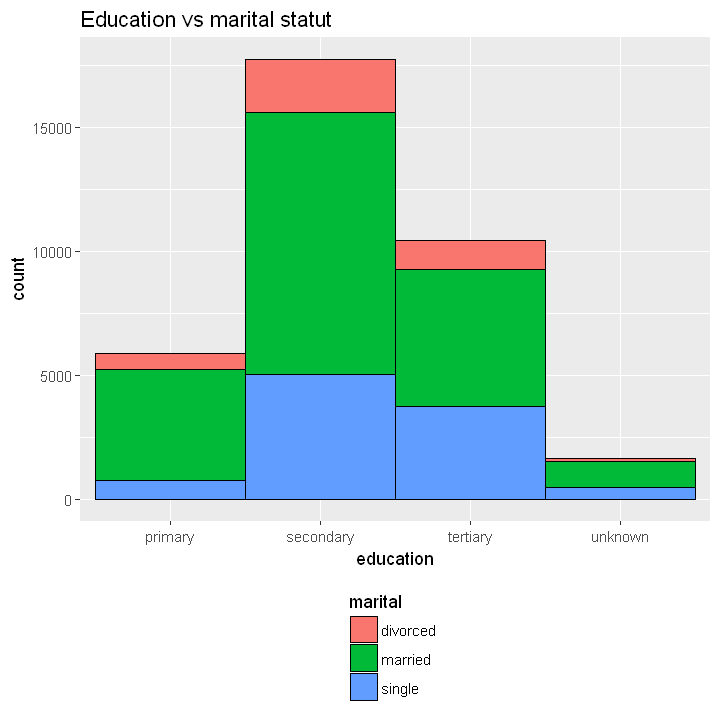

In [9]:
bank %>%
  ggplot(mapping = aes(education)) +
  geom_bar(aes(fill=marital), width=1, color="black") +
  theme(legend.position = "bottom", legend.direction = "vertical") + ggtitle("Education vs marital statut")

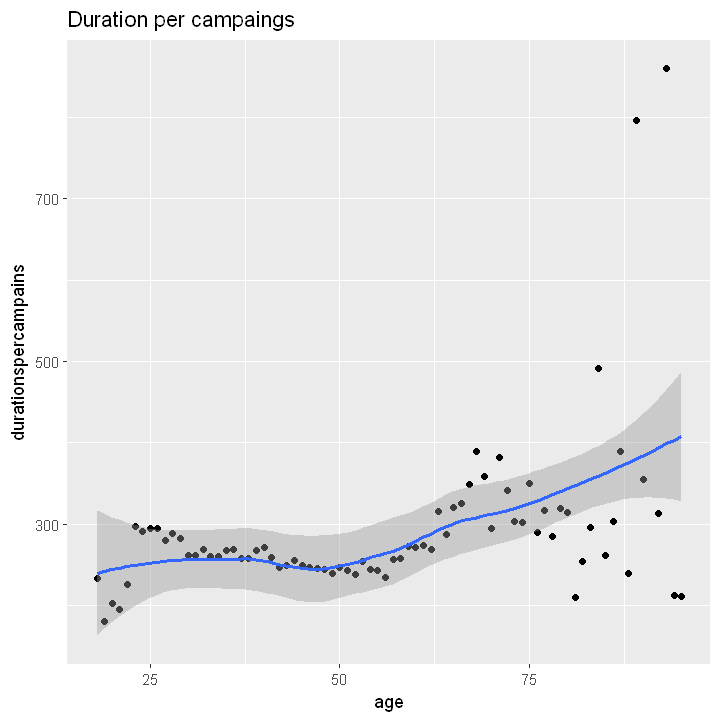

In [10]:
bank %>%
  dplyr::group_by(age = age) %>%
  dplyr::summarize(
    totalcampaigns = n(),
    totaldurations = sum(duration),
    durationspercampains = totaldurations / totalcampaigns
  ) %>%
  ggplot(mapping = aes(x = age, y = durationspercampains)) +
  geom_point() +
  geom_smooth(method = "loess") + ggtitle("Duration per campaings")

bank_id,age,name,opponentName,homeVenue,neutralVenue,ga,gd,w,l,d,friendly,qualifier,finaltourn


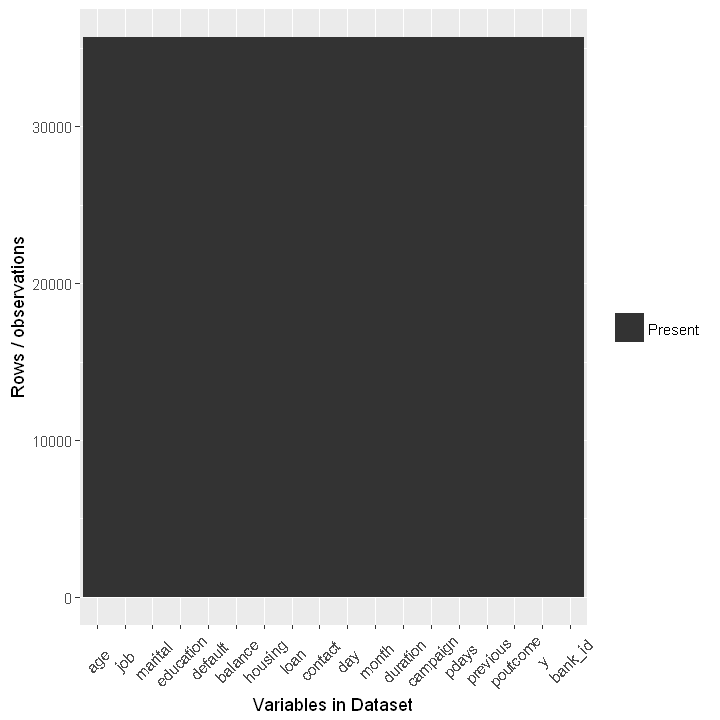

In [11]:
# what values is our dataset missing?

ggplot_missing <- function(x){
  
  x %>%
    is.na %>%
    melt %>%
    ggplot(mapping = aes(x = Var2,
                         y = Var1)) +
    geom_raster(aes(fill = value)) +
    scale_fill_grey(name = "",
                    labels = c("Present","Missing")) +
    theme(axis.text.x  = element_text(angle=45, vjust=0.5)) +
    labs(x = "Variables in Dataset",
         y = "Rows / observations")
}

ggplot_missing(bank)

bank <- bank %>% dplyr::filter("tertiary" == FALSE)

bankperf <- bank %>%
  dplyr::mutate(
    name = job,
    opponentName = marital,
    homeVenue = education,
    neutralVenue = default,
    gs = balance > 1000,
    ga = duration < 150,
    gd = gs - ga,
    w = education == "tertiary" & marital =="marrid",
    l = education == "tertiary",
    d = balance[1] <- 1000,
    friendly = balance[1] <- 1000,
    qualifier = balance,
    finaltourn = housing
    ) %>%
  dplyr::select (bank_id,age, name, opponentName, homeVenue, neutralVenue, ga, gd, w, l, d, friendly, qualifier, finaltourn)

head(bankperf)